In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hotel-reviews/hotel_reviews.csv


# ****Import Libraries****

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
#import sweetviz
#import autosklearn.classification
from wordcloud import WordCloud,STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# ****Importing the Dataset****

In [3]:
hotel = pd.read_csv("/kaggle/input/hotel-reviews/hotel_reviews.csv")


# ****Data Cleaning and EDA****

In [4]:
hotel.head()

,Index,Name,Area,Review_Date,Rating_attribute,Rating(Out of 10),Review_Text
0,0,Hotel The Pearl,"Paharganj, New Delhi",Jul-23,Best budget friendly hotel,9.0,Hotel the pearl is perfect place to stay in De...
1,1,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Amazing place,9.0,Location of the hotel is perfect. The hotel is...
2,2,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Overall good stay. Economic.,9.0,"Location, Indian food."
3,3,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Lovely,9.0,The location and the hotel itself is great. Ne...
4,4,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Great hotel Great staff and great staying,9.0,Friendly and smiling staffs.. The reception st...


In [5]:
print(hotel.shape)
hotel.info()

(7001, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7001 entries, 0 to 7000
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Index              7001 non-null   int64  
 1   Name               7001 non-null   object 
 2   Area               7001 non-null   object 
 3   Review_Date        7001 non-null   object 
 4   Rating_attribute   7001 non-null   object 
 5   Rating(Out of 10)  7001 non-null   float64
 6   Review_Text        6996 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 383.0+ KB


In [6]:
#checking the sum of null in the dataset
hotel.isnull().sum()

Index                0
Name                 0
Area                 0
Review_Date          0
Rating_attribute     0
Rating(Out of 10)    0
Review_Text          5
dtype: int64

In [7]:
#checking the number of unique items in the dataset
for column in hotel.columns:
    print(column, ":", hotel[column].nunique())

Index : 7001
Name : 570
Area : 31
Review_Date : 36
Rating_attribute : 1875
Rating(Out of 10) : 12
Review_Text : 3903


In [8]:
#dropping unnecessary columns
hotel.drop(["Index"], inplace = True, axis = 1)
hotel.head()

,Name,Area,Review_Date,Rating_attribute,Rating(Out of 10),Review_Text
0,Hotel The Pearl,"Paharganj, New Delhi",Jul-23,Best budget friendly hotel,9.0,Hotel the pearl is perfect place to stay in De...
1,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Amazing place,9.0,Location of the hotel is perfect. The hotel is...
2,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Overall good stay. Economic.,9.0,"Location, Indian food."
3,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Lovely,9.0,The location and the hotel itself is great. Ne...
4,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Great hotel Great staff and great staying,9.0,Friendly and smiling staffs.. The reception st...


In [9]:
#seeing if we have duplicates in our dataframe
duplicates = hotel.duplicated().sum()
print("Number of duplicates: ", hotel.duplicated().sum())
#dropping the duplicates
hotel.drop_duplicates(inplace = True)
hotel.shape

Number of duplicates:  2315


(4686, 6)

In [10]:
#dropping null 
hotel.dropna(inplace = True)
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4682 entries, 0 to 6991
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               4682 non-null   object 
 1   Area               4682 non-null   object 
 2   Review_Date        4682 non-null   object 
 3   Rating_attribute   4682 non-null   object 
 4   Rating(Out of 10)  4682 non-null   float64
 5   Review_Text        4682 non-null   object 
dtypes: float64(1), object(5)
memory usage: 256.0+ KB


In [11]:
hotel.describe()

,Rating(Out of 10)
count,4682.000000
mean,6.958864
std,2.909228
min,1.000000
25%,6.000000
50%,8.000000
75%,9.000000
max,10.000000


# **Data Visualizations**

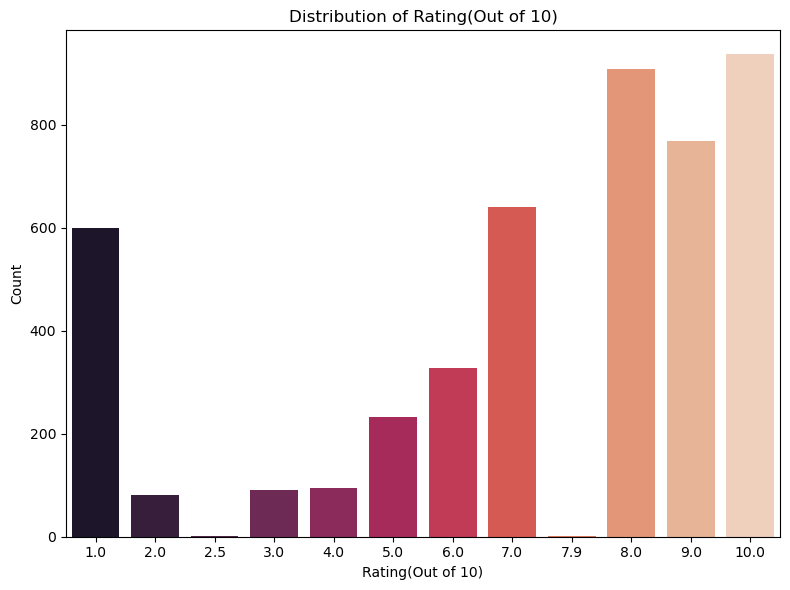

In [12]:
rating = hotel["Rating(Out of 10)"].value_counts().to_frame().reset_index()
plt.figure(figsize = (8,6))
sns.barplot(data = rating, x = "index", y = "Rating(Out of 10)", palette = "rocket")
plt.title("Distribution of Rating(Out of 10)")
plt.xlabel("Rating(Out of 10)")
plt.ylabel("Count")
plt.tight_layout();

/tmp/ipykernel_20/2489326881.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout();


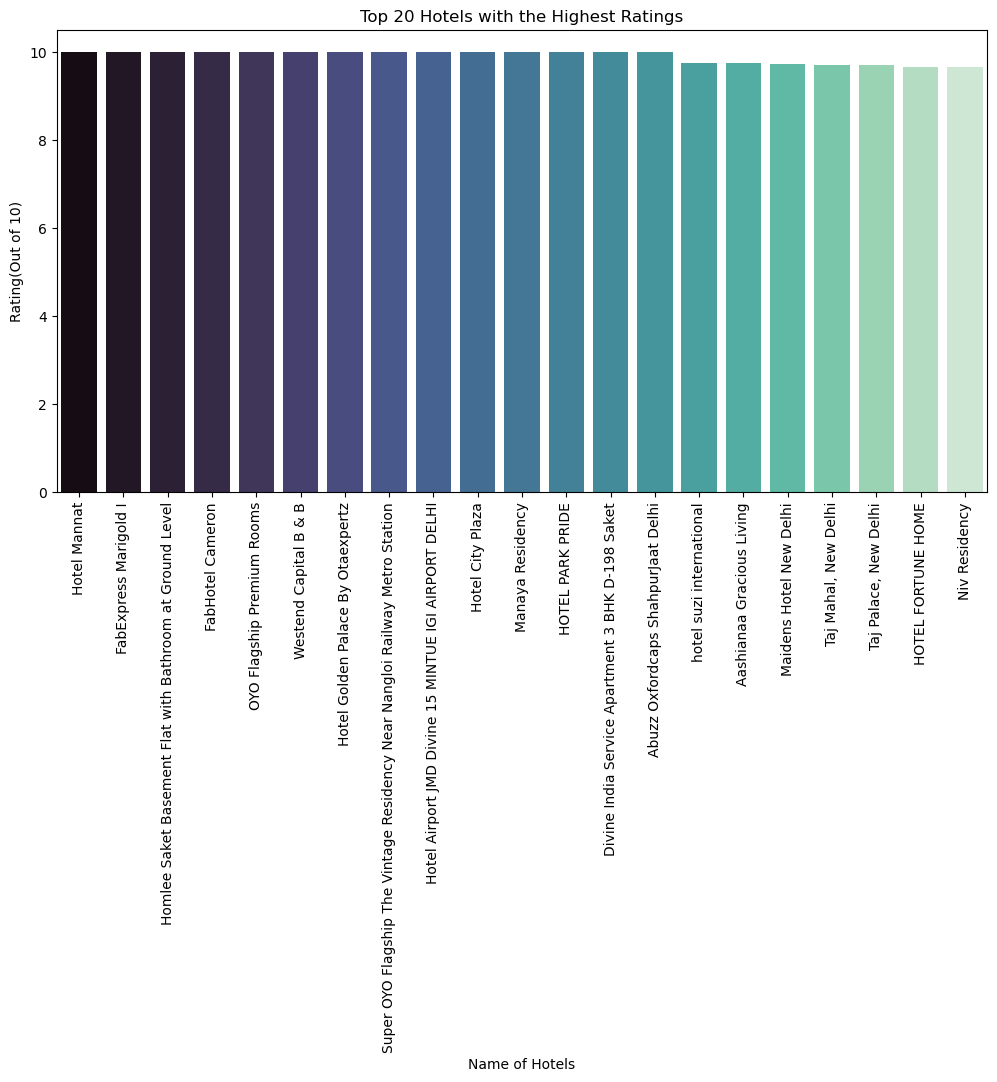

In [13]:
#visualization for the country with the higest rating(out of 10)
plt.figure(figsize = (12,6))
name_df = (hotel.groupby("Name")["Rating(Out of 10)"].mean().to_frame().sort_values(by ="Rating(Out of 10)", ascending =False)
           .reset_index()).head(21)
sns.barplot(x = "Name", y = "Rating(Out of 10)", data = name_df, palette = "mako")
plt.title("Top 20 Hotels with the Highest Ratings")
plt.xlabel("Name of Hotels")
plt.xticks(rotation = 90)
plt.tight_layout();

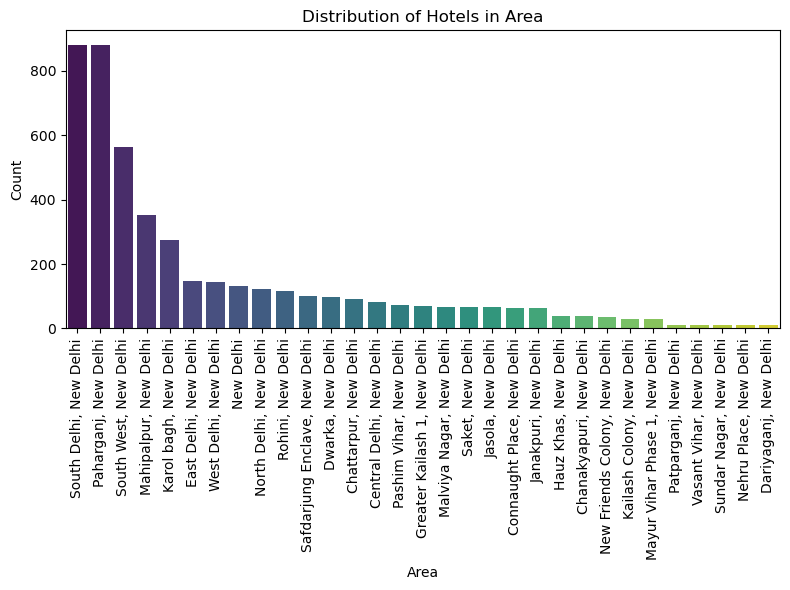

In [14]:
#distribution of area
area = hotel["Area"].value_counts().to_frame().reset_index()
plt.figure(figsize = (8,6))
sns.barplot(data = area, x ="index", y = "Area", palette = "viridis")
plt.title("Distribution of Hotels in Area")
plt.xticks(rotation = 90)
plt.xlabel("Area")
plt.ylabel("Count")
plt.tight_layout();

# **Data Prep for Further Analysis**

In [15]:
#encoding our rating(out of 10) column for better visualization
def rating(rate):
    if rate["Rating(Out of 10)"] <=3.0:
        new_rate = "Negative"
    elif rate["Rating(Out of 10)"] >= 7.0:
        new_rate = "Positive"
    else:
        new_rate = "Neutral"
    return new_rate

#applying the function on our Rating(Out of 10) column
hotel["Rating(Out of 10)"] = hotel.apply(rating, axis = 1)

hotel.head()

,Name,Area,Review_Date,Rating_attribute,Rating(Out of 10),Review_Text
0,Hotel The Pearl,"Paharganj, New Delhi",Jul-23,Best budget friendly hotel,Positive,Hotel the pearl is perfect place to stay in De...
1,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Amazing place,Positive,Location of the hotel is perfect. The hotel is...
2,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Overall good stay. Economic.,Positive,"Location, Indian food."
3,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Lovely,Positive,The location and the hotel itself is great. Ne...
4,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Great hotel Great staff and great staying,Positive,Friendly and smiling staffs.. The reception st...


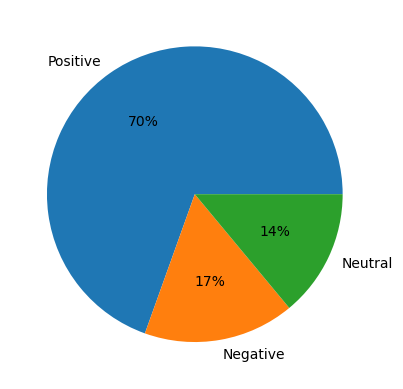

In [16]:
#creating a pie chart for our Rating(Out of 10) column to see the distribution of positive and negative
rate = dict(hotel["Rating(Out of 10)"].value_counts())
plt.pie(rate.values(), labels = rate.keys(), autopct='%.0f%%')
plt.show();

In [17]:
#streamlining our dataset to just our feature and target
hotel_df = hotel[["Rating_attribute", "Rating(Out of 10)"]].copy()
hotel_df.head()

,Rating_attribute,Rating(Out of 10)
0,Best budget friendly hotel,Positive
1,Amazing place,Positive
2,Overall good stay. Economic.,Positive
3,Lovely,Positive
4,Great hotel Great staff and great staying,Positive


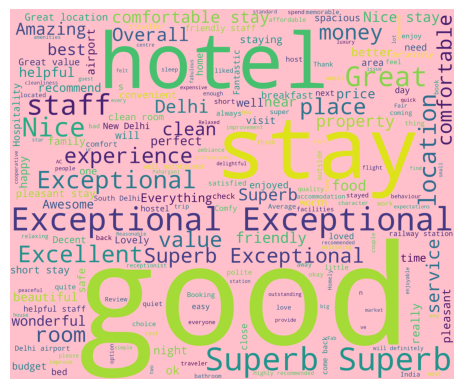

In [18]:
# WordCloud - Sentiment Positive

hotel_df1 = hotel_df[hotel_df['Rating(Out of 10)']== 'Positive']
words = ' '.join(hotel_df1['Rating_attribute'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='pink',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

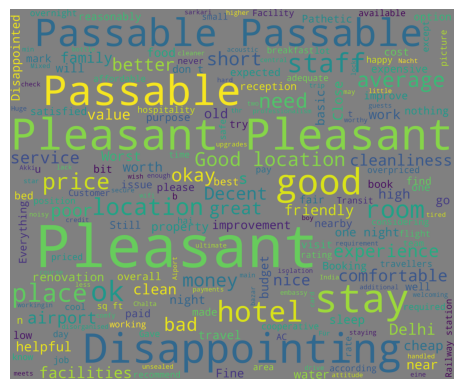

In [19]:
# WordCloud - Sentiment Neutral

hotel_df3 = hotel_df[hotel_df['Rating(Out of 10)']== 'Neutral']
words = ' '.join(hotel_df3['Rating_attribute'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='grey',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

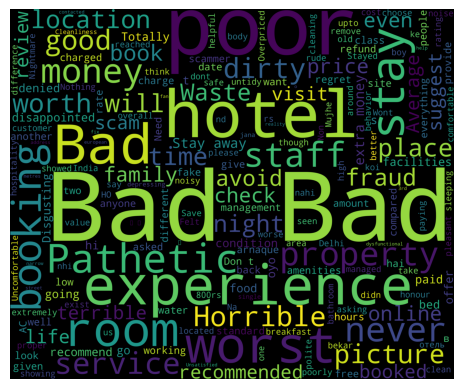

In [20]:
# WordCloud - Sentiment Negative

hotel_df2 = hotel_df[hotel_df['Rating(Out of 10)']== 'Negative']
words = ' '.join(hotel_df2['Rating_attribute'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='black',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [21]:
def reviews_to_words(tweet):
    letters_only = re.sub('[^a-zA-Z]',' ',tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_word = [w for w in words if w not in stops]
    return ' '.join(meaningful_word)



def review_len(tweet):
    letters_only = re.sub('[^a-zA-Z]',' ',tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_word = [w for w in words if w not in stops]
    return (len(meaningful_word))

def hotel_rating(rate):
    if rate== 'Positive' or rate =='Neutral':
        val =  1
    else:
        val = 0
    return val

In [22]:
hotel_df['Ratings'] = hotel_df['Rating(Out of 10)'].apply(hotel_rating)
hotel_df['clean_review'] = hotel_df['Rating_attribute'].astype(str).apply(lambda x:reviews_to_words(x))
hotel_df['review_length'] = hotel_df['Rating_attribute'].astype(str).apply(lambda x:review_len(x))
train_data, test_data = train_test_split(hotel_df,test_size=0.2,random_state=123)

hotel_df[hotel_df["Rating(Out of 10)"] == "Negative"]

,Rating_attribute,Rating(Out of 10),Ratings,clean_review,review_length
95,Unsatisfied and very disappointed.,Negative,0,unsatisfied disappointed,2
120,3rd class hotel,Negative,0,rd class hotel,3
145,Bad,Negative,0,bad,1
146,Bad,Negative,0,bad,1
147,Very poor,Negative,0,poor,1
...,...,...,...,...,...
6941,Bad,Negative,0,bad,1
6942,Bad,Negative,0,bad,1
6943,Bad,Negative,0,bad,1
6944,Bad,Negative,0,bad,1


In [23]:
train_clean_review = []
for review in train_data['clean_review']:
    train_clean_review.append(review)
test_clean_review = []
for review in test_data['clean_review']:
    test_clean_review.append(review)
    
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer='word')
train_features = v.fit_transform(train_clean_review)
test_features = v.transform(test_clean_review)

In [24]:
#list of models 
classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200)]

In [25]:
Accuracy=[]
Model=[]
#loop to fit, predict and return the accuracy score of our model
for classifier in classifiers:
    fit = classifier.fit(train_features,train_data['Ratings'])
    pred = fit.predict(test_features)
    accuracy = round(accuracy_score(pred,test_data['Ratings'])*100, 2)
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is: '+str(accuracy) +'%')

Accuracy of LogisticRegression is: 84.1%
Accuracy of DecisionTreeClassifier is: 94.34%
Accuracy of RandomForestClassifier is: 95.41%
